<a href="https://colab.research.google.com/github/JaiSuryaPrabu/deep_learning/blob/main/3_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch module

* `torchvision`
* `torchvision.datasets`
* `torchvision.models`
* `torchvision.transforms`
* `torch.utils.data.Dataset`
* `torch.utils.data.DataLoader`

In [35]:
# libs
import torch
from torch import nn

# vision libraries
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Dataset

In [37]:
# training data
training_data = datasets.FashionMNIST(
    root = "data", # path
    train = True, # set as training data
    download = True, # to download if the data is not in the hard disk
    transform = ToTensor(), # by default data is in PIL format
    target_transform= None # to transform to labels as well
)

In [38]:
# testing data
testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [39]:
# shape , size , dimensions
image , label = training_data[0]
image.size(),image.ndim

(torch.Size([1, 28, 28]), 3)

In [40]:
# the recommended format is NHWC - [Number of images , Height , Width , Color channels]
# to see how many data and its classes
len(training_data.data),len(training_data.targets),training_data.classes

(60000,
 60000,
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

## Vis the data

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

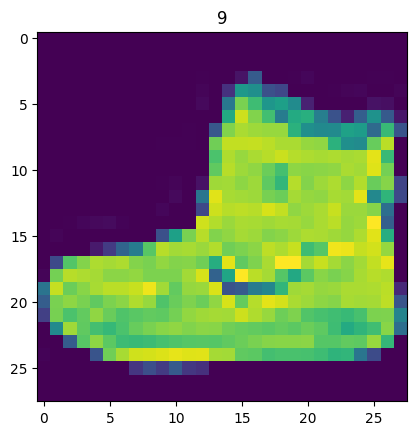

In [41]:
import matplotlib.pyplot as plt
image, label = training_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label)

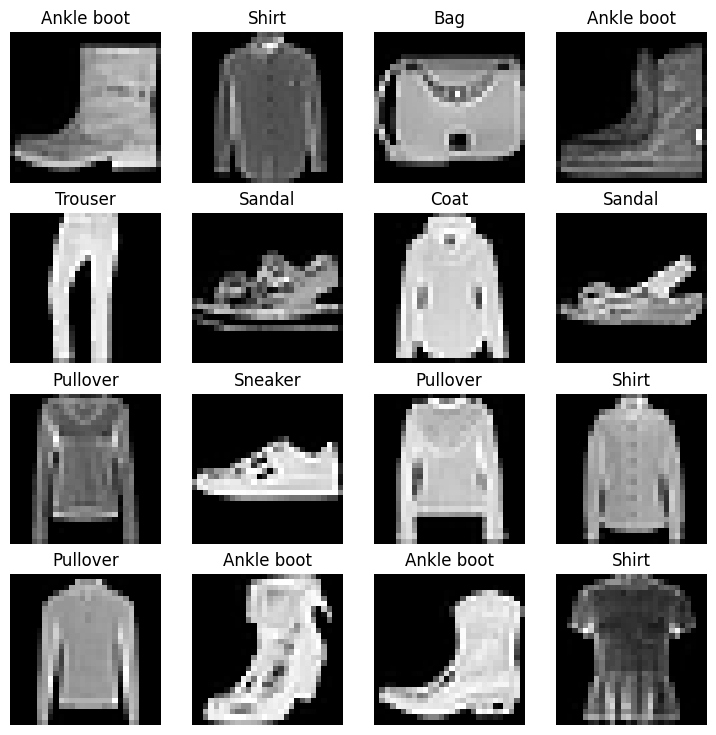

In [42]:
class_names = training_data.classes
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(training_data), size=[1]).item()
    img, label = training_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

# DataLoader

In [46]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# training data loader
train_data_loader = DataLoader(training_data,
                               batch_size = BATCH_SIZE,
                               shuffle = True)

# testing data loader
test_data_loader = DataLoader(testing_data,
                              batch_size=BATCH_SIZE)

In [47]:
len(train_data_loader),len(test_data_loader)

(1875, 313)

In [48]:
# to see inside the training data
training_data_size , training_data_batch = next(iter(train_data_loader))
training_data_size.shape , training_data_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# Model

We use two layers 
* Flatten()
* Linear()
The structure data :
* Excel
* CSV
The algorithms best for the structured : 
* `sklearn.ensemble`
* XGBoost
The unstructured data are :
* Audio
* Images
* Languages
The algorithms best for the unstructured data:
* CNN
* Transformer

The structure is taken from the https://poloclub.github.io/cnn-explainer/

In [49]:
class imageClassifier(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels = input_shape,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )        
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )

    def forward(self,input):
        input = self.block1(input)
        input = self.block2(input)
        input = self.classifier(input)
        return input

In [51]:
model = imageClassifier(input_shape = 1,hidden_units = 10,output_shape = len(class_names)).to(device)
model

imageClassifier(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [52]:
# loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.1)

In [55]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

# training testing phase

epochs = 3

for epoch in tqdm(range(epochs)):

    # training phase
    model.train()

    train_loss = 0
    train_acc = 0
    for batch , (X,y) in enumerate(train_data_loader):
        # tensor to gpu
        X = X.to(device)
        y = y.to(device)

        # 1. Forward pass
        pred = model(X)

        # 2. Loss
        loss = loss_fn(pred,y)
        train_loss += loss

        # zero grad
        optimizer.zero_grad()

        # backward
        loss.backward()

        # step
        optimizer.step()
    
    print(f"Epoch {epoch} Training loss {train_loss/len(train_data_loader):.4f}")

    # testing phase
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.inference_mode():
        for X,y in test_data_loader:
            X = X.to(device)
            y = y.to(device)

            # forward pass
            test_pred = model(X)

            # loss
            test_loss = loss_fn(test_pred,y)
        print(f"Epoch {epoch} Testing loss {test_loss/len(train_data_loader):.4f}")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0 Training loss 0.5909
Epoch 0 Testing loss 0.0001
Epoch 1 Training loss 0.3575
Epoch 1 Testing loss 0.0002
Epoch 2 Training loss 0.3205
Epoch 2 Testing loss 0.0002


# Viz

In [56]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(testing_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [58]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [59]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model, 
                             data=test_samples)

# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 6, 4, 7, 1])

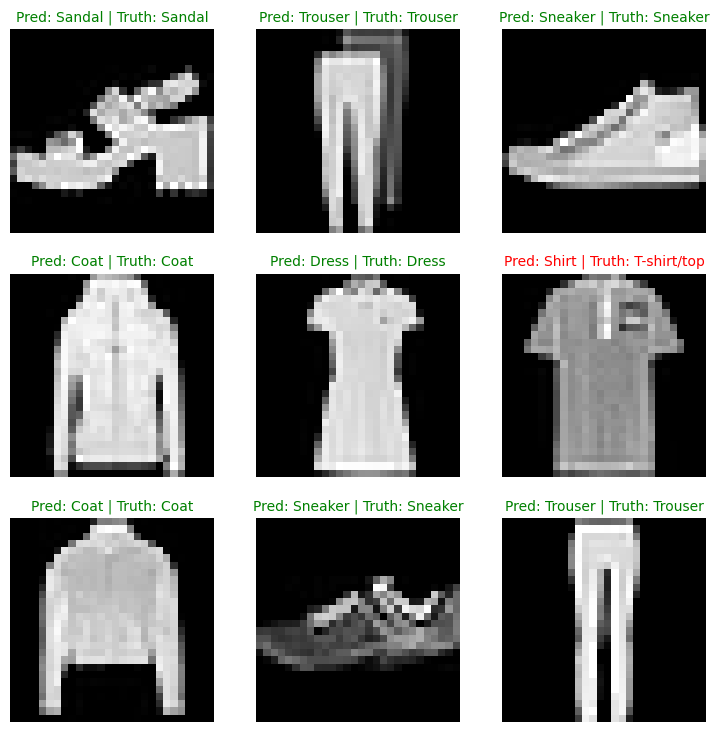

In [60]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)